In [1]:
#below is from https://medium.com/analytics-vidhya/exploratory-data-analysis-for-beginner-7488d587f1ec

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = "ticks")  
#style = 'dark','darkgrid','whitegrid' are some other styles 

In [2]:
hydrated = pd.read_csv(r'data\COMPLETEhydrated.csv', dtype = 'unicode')

In [3]:
hydrated.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id_str,letter_id_str,from_user,text,created_at,user_lang,from_user_id_str,...,status_url,retweet_count,favorite_count,user_description,user_created_at,user_listed_count,user_statuses _count,user_profile_background_image_url,user_verified,user_favourites_count
0,0,0,0,1.32E+18,v1320095827738624000,theluthier63,RT @davietweetsc: Gulf War Syndrome: Documents...,Sat Oct 24 20:12:26 +0000 2020,NaN,9.03E+17,...,http://twitter.com/theluthier63/statuses/13200...,2,NaN,falklands Gulf war 1 veteran Sir Galahad surv...,Tue Aug 29 14:36:09 +0000 2017,NaN,35836,NaN,NaN,41994
1,1,1,1,1.32E+18,v1320089561159094273,realBenTalks,Governor Cuomo Announces Draft New York State ...,Sat Oct 24 19:47:32 +0000 2020,NaN,226310002,...,http://twitter.com/realBenTalks/statuses/13200...,NaN,NaN,#Information #Scientist | MLIS @UWM | #IT & #M...,Mon Dec 13 21:24:29 +0000 2010,3193,972305,http://abs.twimg.com/images/themes/theme1/bg.png,NaN,66487
2,2,2,2,1.32E+18,v1320089244631769089,Carolwa35933143,RT @kvwatchtay7: Breaking: The WHO say Covid19...,Sat Oct 24 19:46:16 +0000 2020,NaN,1.18E+18,...,http://twitter.com/Carolwa35933143/statuses/13...,8060,NaN,Happy granny with an opinion ! not one I feel ...,Wed Oct 02 05:52:13 +0000 2019,1,7868,NaN,NaN,27495
3,3,3,3,1.32E+18,v1320094246314139648,realBenTalks,"County offering free flu vaccination clinics, ...",Sat Oct 24 20:06:09 +0000 2020,NaN,226310002,...,http://twitter.com/realBenTalks/statuses/13200...,NaN,NaN,#Information #Scientist | MLIS @UWM | #IT & #M...,Mon Dec 13 21:24:29 +0000 2010,3193,972305,http://abs.twimg.com/images/themes/theme1/bg.png,NaN,66487
4,4,4,4,1.32E+18,v1320093393360400384,pavsmith,RT @Rosewind2007: I’d add that I’m not saying ...,Sat Oct 24 20:02:45 +0000 2020,NaN,75338695,...,http://twitter.com/pavsmith/statuses/132009339...,2,NaN,An autonomous anarcho syndicalist collective o...,Fri Sep 18 17:41:24 +0000 2009,28,32485,http://abs.twimg.com/images/themes/theme1/bg.png,NaN,5930


In [4]:
hydrated.describe()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id_str,letter_id_str,from_user,text,created_at,user_lang,from_user_id_str,...,status_url,retweet_count,favorite_count,user_description,user_created_at,user_listed_count,user_statuses _count,user_profile_background_image_url,user_verified,user_favourites_count
count,292271,292271,292271,292271,292270,292271,292270,292255,4,292255,...,292255,196636,57054,258379,292247,224935,292247,203034,16470,289120
unique,292271,292271,203827,120404,292270,167161,157027,270635,4,135154,...,292255,592,737,148310,166770,4079,80836,20,2,95241
top,427813,427813,8962,1.33E+18,v1327464791351328768,realBenTalks,"RT @pfizer: UPDATE: We are proud to announce, ...",Thu Dec 10 01:04:34 +0000 2020,48030,226310002,...,http://twitter.com/LseNeon/statuses/1322875054...,1,1,#Information #Scientist | MLIS @UWM | #IT & #M...,Mon Dec 13 21:24:29 +0000 2010,1,972305,http://abs.twimg.com/images/themes/theme1/bg.png,TRUE,66487
freq,1,1,2,105940,1,2671,6664,13,1,2671,...,1,17766,12998,1412,2671,15185,1206,143351,9420,1222


In [3]:
hydrated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292271 entries, 0 to 292270
Data columns (total 24 columns):
Unnamed: 0                           292271 non-null object
Unnamed: 0.1                         292271 non-null object
Unnamed: 0.1.1                       292271 non-null object
id_str                               292271 non-null object
letter_id_str                        292270 non-null object
from_user                            292271 non-null object
text                                 292270 non-null object
created_at                           292255 non-null object
user_lang                            4 non-null object
from_user_id_str                     292255 non-null object
profile_image_url                    292239 non-null object
user_followers_count                 291496 non-null object
user_friends_count                   290225 non-null object
user_location                        213873 non-null object
status_url                           292255 non-null o

In [4]:
#converting to float

hydrated["retweet_count"] = pd.to_numeric(hydrated["retweet_count"], downcast="float")
                                                   
hydrated["favorite_count"] = pd.to_numeric(hydrated["favorite_count"], downcast="float")
                                                   
hydrated["user_listed_count"] = pd.to_numeric(hydrated["user_listed_count"],downcast="float")

hydrated["user_statuses_count"] = pd.to_numeric(hydrated["user_statuses _count"], downcast="float")
     
hydrated["user_favorites_count"] = pd.to_numeric(hydrated["user_favourites_count"], downcast="float")

In [5]:
hydrated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292271 entries, 0 to 292270
Data columns (total 26 columns):
Unnamed: 0                           292271 non-null object
Unnamed: 0.1                         292271 non-null object
Unnamed: 0.1.1                       292271 non-null object
id_str                               292271 non-null object
letter_id_str                        292270 non-null object
from_user                            292271 non-null object
text                                 292270 non-null object
created_at                           292255 non-null object
user_lang                            4 non-null object
from_user_id_str                     292255 non-null object
profile_image_url                    292239 non-null object
user_followers_count                 291496 non-null object
user_friends_count                   290225 non-null object
user_location                        213873 non-null object
status_url                           292255 non-null o

In [6]:
# Here .astype() will cast all df object as "true", instead we can use "==" to match if the content is true
# hydrated['user_verified'] = hydrated['user_verified'].astype('bool')
hydrated['user_verified'] = hydrated['user_verified']=="True"

In [7]:
hydrated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292271 entries, 0 to 292270
Data columns (total 26 columns):
Unnamed: 0                           292271 non-null object
Unnamed: 0.1                         292271 non-null object
Unnamed: 0.1.1                       292271 non-null object
id_str                               292271 non-null object
letter_id_str                        292270 non-null object
from_user                            292271 non-null object
text                                 292270 non-null object
created_at                           292255 non-null object
user_lang                            4 non-null object
from_user_id_str                     292255 non-null object
profile_image_url                    292239 non-null object
user_followers_count                 291496 non-null object
user_friends_count                   290225 non-null object
user_location                        213873 non-null object
status_url                           292255 non-null o

In [8]:
# Don't seem to need this, if we want the sum of the verified user we can count df directly
# print(hydrated.isnull().values.sum())
hydrated['user_verified'].value_counts()

#if I needed to convert to NaN, or a "float"
#https://www.analyticsvidhya.com/blog/2020/08/exploratory-data-analysiseda-from-scratch-in-python/ 

901259


In [9]:
# We can also group it by selecting id_str or letter_id_str to see how many unique entires
hydrated.groupby('user_verified')[['id_str','letter_id_str']].nunique()


array([ True,  True,  True, ...,  True,  True,  True])

C:\Users\sewal\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\sewal\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Count')

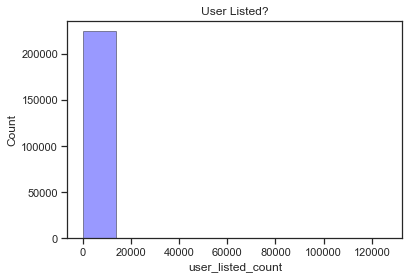

In [19]:
# seaborn histogram 

#not really sure what categories will be useful/possible here
sns.distplot(hydrated['user_listed_count'], hist=True, kde=False, 
             bins=9, color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('User Listed?')
plt.xlabel('user_listed_count')
plt.ylabel('Count')

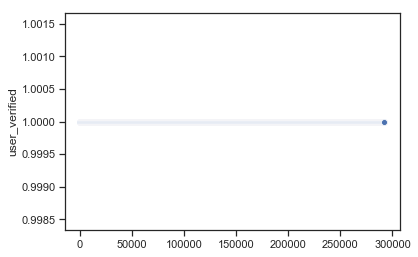

In [35]:
sns.scatterplot(x=np.linspace(1,292271, num=292271), y=hydrated['user_verified'])
#(x=hydrated['user_verified'],
                #y=hydrated['user_statuses_count'])

In [27]:
print(hydrated["user_verified"==1])

KeyError: False

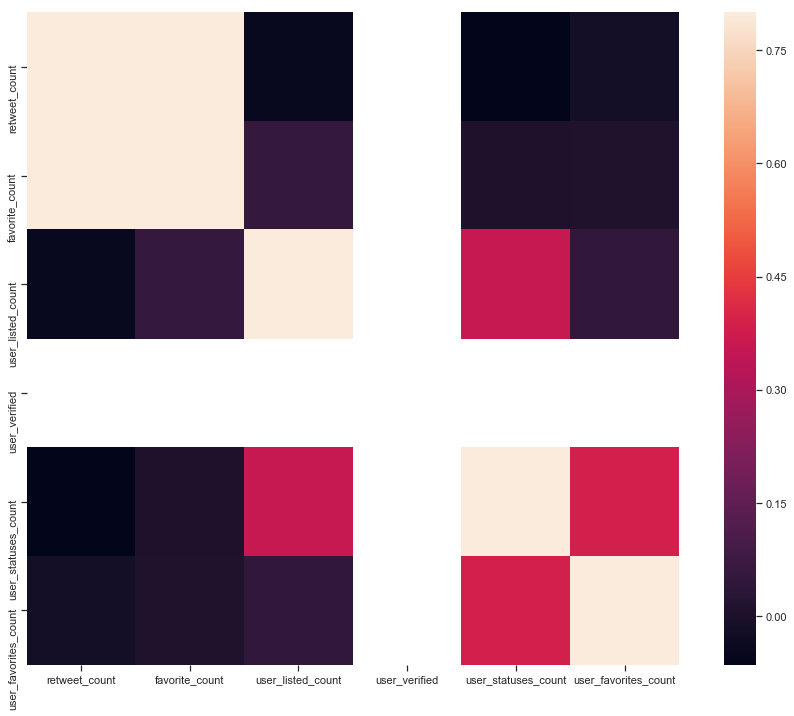

In [25]:
#Heat map pearson correlation matrix
corrmat = hydrated.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

#Light color, i.e., see on the right, scale 0.8 is highly correlated, 
#and darker color below or around -0.2 is not correlated.

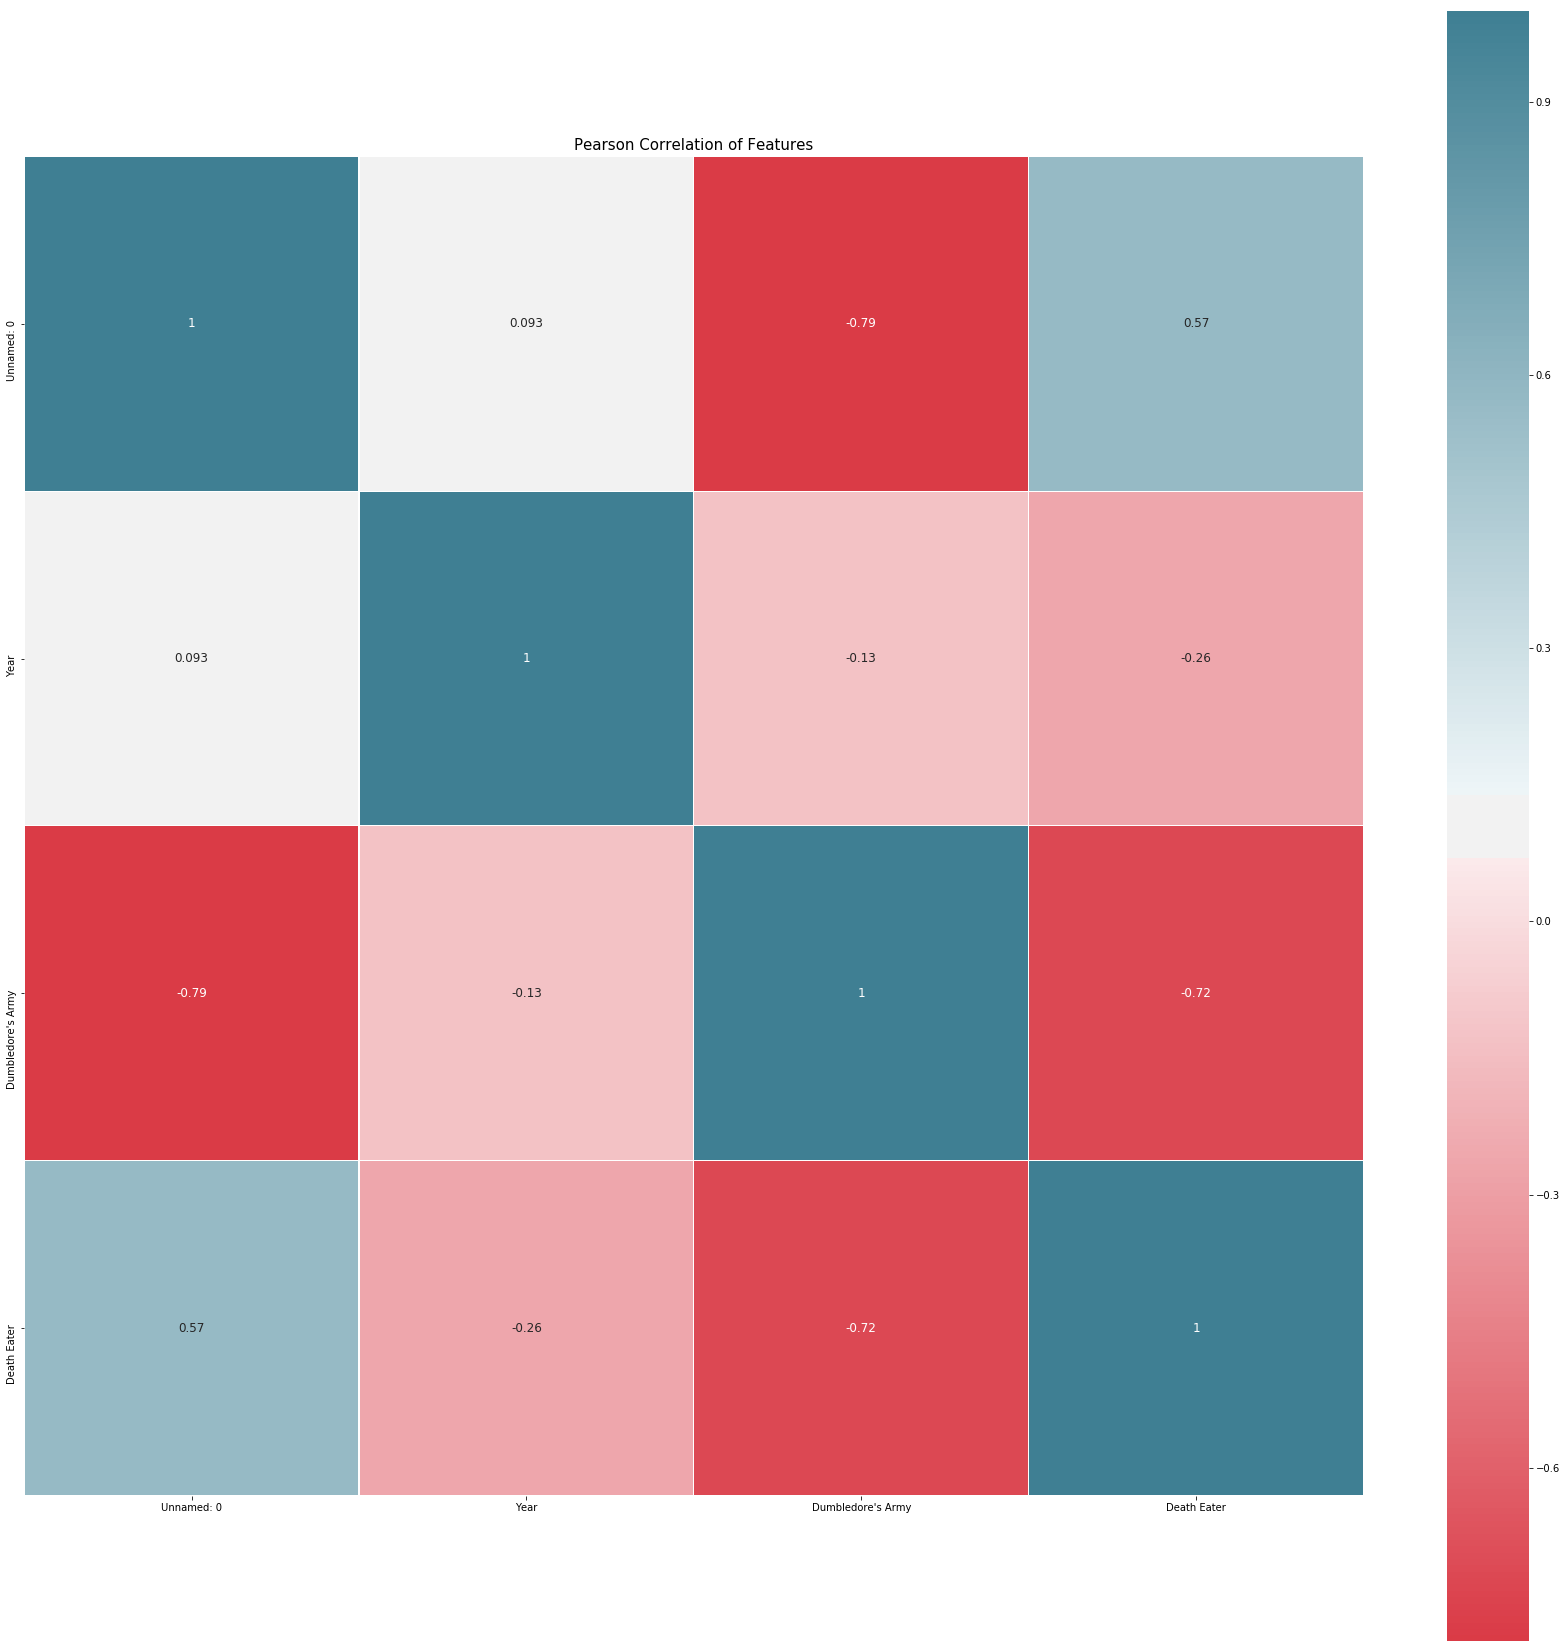

In [12]:
# Your heatmap is correct, you just forgot to change the dataframe name from pottermerged --> hydrated
plt.figure(figsize=(30,30))
plt.title('Pearson Correlation of Features', size = 15)
colormap = sns.diverging_palette(10, 220, as_cmap = True)
sns.heatmap(hydrated.corr(),
            cmap = colormap,
            square = True,
            annot = True,
            linewidths=0.1,vmax=1.0, linecolor='white',
            annot_kws={'fontsize':12 })
plt.show()

#In above correlation matrix, we printed the number also so it will be easy for us 
#to see which are highly correlated and value close to 1.00 is highly correlated.